# Layer activation normalization (Batch normalization)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/4.batch-normalization.ipynb)

By [Terence Parr](https://explained.ai).

Just as we normalize or standardize the input variables, networks train better if we normalize the output of each layer's activation. It is called batch normalization because we normally train with batches of records not the entire data set, but it's really just fixing the mean and variance of each layer activation to zero mean and unit variance.

Batch normalization does not use the joint distribution. Each neuron activation is "whitened" independently. Then, we scale and shift using two new model parameters to support same representation as previous layer activation. At test time, we use mean/var estimated during training for activtions to whiten the activations as the test instance sails through the network. The learned parameters scale and shift the layer output but do not change the shape of the distribution. This technique helps move gradients through the network during training.

as training progresses, the input to a hidden layer changes distribution (internal covariate shift), which means that the hidden layer weights must change as well. Small changes at the first layer amplify through deep networks. As with normalizing the input layer, it is believed to support faster learning rates for faster training. It also has a regularization effect, improving model generality. The model could also be less sensitive to the initialization procedure.  See [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167) for more information.

because mean/var computed on mini-batch we get some noise, which regularizes like dropout. Andrew Ng says slight effect, not as good as dropout for regularization. More about speeding up training.

See video [Why Does Batch Norm Work?](https://www.youtube.com/watch?v=nUUqwaxLnWs)

## Support code

In [1]:
import os
import sys
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [2]:
def plot_history(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")

In [3]:
def train(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"BEST MSE test loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

In [4]:
d = load_diabetes()
len(d.data)

442

In [5]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [6]:
np.random.seed(1) # set a random seed for consistency across runs
n = len(df)
n_test = int(n*0.20) # 20% held out as validation set
n_train = n - n_test
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [7]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [8]:
rf = RandomForestRegressor(n_estimators=500)#, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 455.43 validation MSE 3405.60


In [9]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## No batch normalization

Epoch    0 MSE train loss    29877.910   test loss    25961.758
Epoch   50 MSE train loss     2673.504   test loss     3063.200
Epoch  100 MSE train loss     2355.150   test loss     3152.397
Epoch  150 MSE train loss     2146.262   test loss     3296.635
Epoch  200 MSE train loss     1937.521   test loss     3484.453
Epoch  250 MSE train loss     1683.252   test loss     3757.381
Epoch  300 MSE train loss     1374.387   test loss     4173.045
Epoch  350 MSE train loss     1111.490   test loss     4566.150
Epoch  400 MSE train loss      885.020   test loss     5018.668
Epoch  450 MSE train loss      711.607   test loss     5215.718
Epoch  500 MSE train loss      582.698   test loss     5368.227
BEST MSE test loss 3028.594 at epoch 46


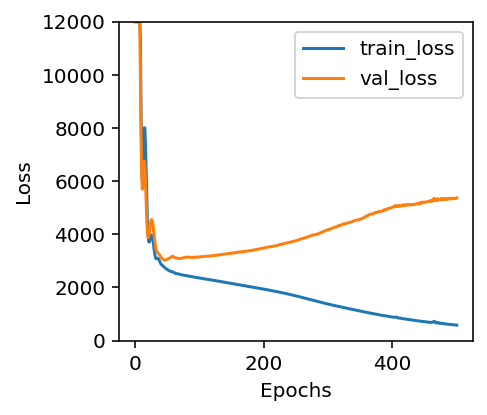

In [10]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train(model, X_train, X_test, y_train, y_test,
                            learning_rate=.05, nepochs=500,
                            weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)

plot_history(torch.clamp(history, 0, 12000))

## Batch normalization prior to nonlinearity


Epoch    0 MSE train loss    29829.938   test loss    25920.430
Epoch   50 MSE train loss     2601.699   test loss     3262.268
Epoch  100 MSE train loss     2348.449   test loss     3186.059
Epoch  150 MSE train loss     2256.018   test loss     3227.803
Epoch  200 MSE train loss     2196.712   test loss     3278.555
Epoch  250 MSE train loss     2151.092   test loss     3313.031
Epoch  300 MSE train loss     2120.953   test loss     3316.872
Epoch  350 MSE train loss     2097.317   test loss     3334.501
Epoch  400 MSE train loss     2080.215   test loss     3329.433
Epoch  450 MSE train loss     2061.467   test loss     3357.720
Epoch  500 MSE train loss     2047.329   test loss     3357.164
BEST MSE test loss 3006.351 at epoch 30


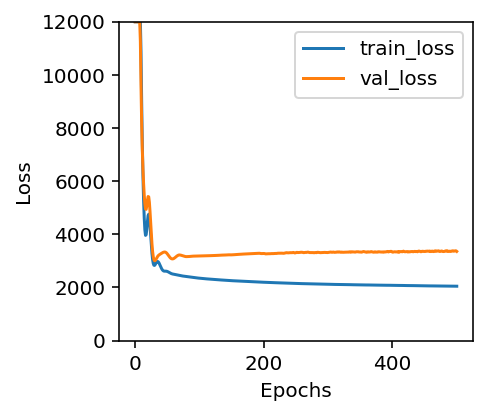

In [11]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.BatchNorm1d(n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train(model, X_train, X_test, y_train, y_test,
                            learning_rate=.05, nepochs=500,
                            weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)

plot_history(torch.clamp(history, 0, 12000))

## Batch normalization after nonlinearity

Epoch    0 MSE train loss    29939.748   test loss    26006.139
Epoch   50 MSE train loss     2164.730   test loss     3728.676
Epoch  100 MSE train loss     1457.743   test loss     4119.281
Epoch  150 MSE train loss      730.021   test loss     4646.351
Epoch  200 MSE train loss      324.814   test loss     6120.327
Epoch  250 MSE train loss      213.437   test loss     7057.322
Epoch  300 MSE train loss       85.807   test loss     8019.500
Epoch  350 MSE train loss       67.641   test loss     8437.455
Epoch  400 MSE train loss       67.963   test loss     8382.595
Epoch  450 MSE train loss       22.308   test loss     8503.005
Epoch  500 MSE train loss       39.178   test loss     8585.216
BEST MSE test loss 3214.412 at epoch 19


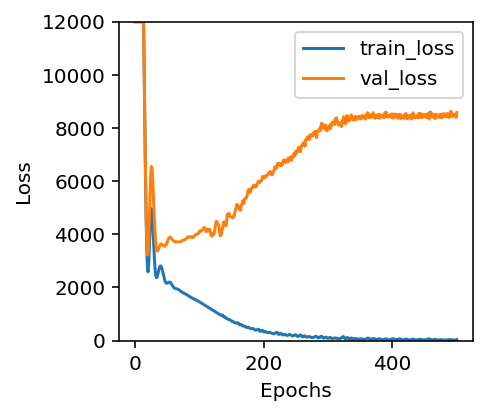

In [12]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.BatchNorm1d(n_neurons),
    nn.Linear(n_neurons, 1)
)

history, best_model = train(model, X_train, X_test, y_train, y_test,
                            learning_rate=.05, nepochs=500,
                            weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)

plot_history(torch.clamp(history, 0, 12000))

At least for this data set and a random train/test set, batch normalization gives us much faster convergence to the best validation loss and also we get a lower test loss:

1. No normalization: BEST MSE test loss 3073.239 at epoch 47
1. Prior to ReLU: BEST MSE test loss 2997.867 at epoch 30
1. Post ReLU: BEST MSE test loss 3073.734 at epoch 19

In the end, this data set is pretty small and perhaps not the most impressive demonstration of batch normalization, but it serves our purposes to demonstrate the technique.